In [1]:
import matplotlib.pyplot as plt
from einops import rearrange

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader


import monai
from monai.transforms import LoadImage
from monai.config import print_config

from scripts.train import LitUnet
import pytorch_lightning as pl

from scripts.utils import *
from scripts.data import *

#print_config()


def predict_and_display_examples(model, n, loader, seed=0):
    torch.manual_seed(seed)
    batch = next(iter(loader))
    x, y = batch

    device = torch.device('cuda:0')
    x = x.to(device)

    pred = model(x)
    prob = F.softmax(pred, dim=1)
    y_pred = torch.argmax(prob, dim=1).cpu()

    plt.figure(figsize=(n, 5))
    plt.imshow(rearrange(y_pred[:n+1], "b h w -> h (b w)"))
    plt.title("prediction")
    plt.show()
    plt.figure(figsize=(n, 5))
    plt.title("Ground Truth")
    plt.imshow(rearrange(y[:n+1], "b h w -> h (b w)"))
    plt.show()

/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
root_directory = "Data/M&Ms/OpenDataset"
transform =  monai.transforms.ScaleIntensity(minv=0.0, maxv=1.0)

train_dataset = Centre2DDataset(6, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

val_dataset = Centre2DDataset(1, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=4)


  0%|          | 0/76 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 70.55it/s]


In [8]:
model = LitUnet(lr=1e-4)

# Training and Validation
trainer = pl.Trainer(max_epochs=40, deterministic=True, log_every_n_steps=2)
trainer.fit(model, train_loader, val_loader)

/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-pac ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-pac ...
  rank_zero_warn(
/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/pytorch_lightning/ca

Epoch 39: 100%|██████████| 222/222 [00:05<00:00, 37.72it/s, v_num=38336]   

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 222/222 [00:05<00:00, 37.34it/s, v_num=38336]


100%|██████████| 19/19 [00:00<00:00, 59.54it/s]


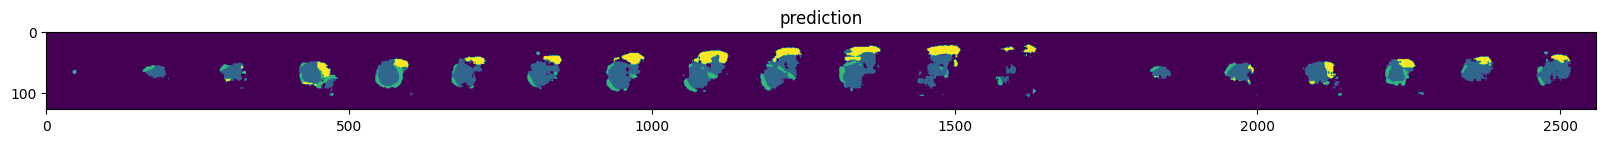

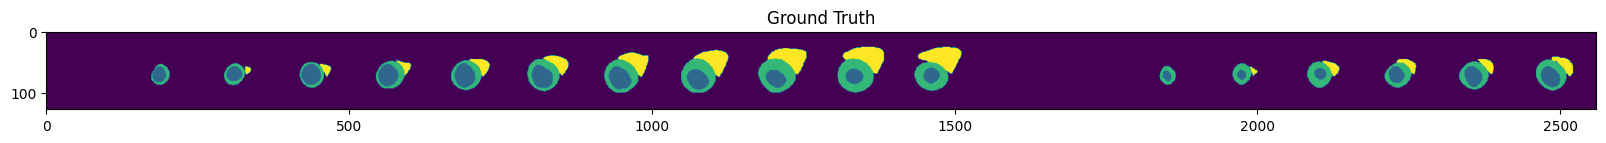

In [28]:
model = LitUnet.load_from_checkpoint("lightning_logs/version_38336/checkpoints/epoch=39-step=8880.ckpt")
model.eval()

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=4)

# predict_and_display_examples(model, 20, train_loader, seed=0)
# predict_and_display_examples(model, 20, val_loader, seed=0)

val_dataset = Centre2DDataset(1, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=20, num_workers=4)
predict_and_display_examples(model, 20, val_loader, seed=0)
